In [1]:
#import os
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
import jax
import juniper as jp

from juniper.GaussKernel import GaussKernel
from juniper.LinearKernelCombination import LinearKernelCombination

from juniper.steps.NeuralField import NeuralField
from juniper.steps.StaticGain import StaticGain
from juniper.steps.DemoInput import DemoInput
from juniper.steps.Projection import Projection
from juniper.steps.Sum import Sum
from juniper.steps.ComponentMultiply import ComponentMultiply


from demo.demo4 import demo4

In [2]:
print("Computing devices found by JAX:")
print(jax.local_devices())

Computing devices found by JAX:
[CpuDevice(id=0)]


In [3]:
arch = jp.Architecture.get_arch()

In [4]:
jp.Architecture.delete_arch()
arch = jp.Architecture.get_arch()
# shape parameter
space_shape = (294, 447)
feature_shape = (3,)
feature_map_shape = space_shape + feature_shape

In [5]:
# objects and scenes
# red = 0, green = 1, blue = 2
# pill = 0, clock = 1, goggles = 2
gauß_sigma = (30,30,0.1)
amp = 1

# scene 1 
red_pill_shape = DemoInput("red_pill_shape", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (147,82,0)})
red_pill_color = DemoInput("red_pill_color", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (147,82,0)})

blue_clock_shape = DemoInput("blue_clock_shape", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (172,325,1)})
blue_clock_color = DemoInput("blue_clock_color", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (172,325,2)})

# scene 2
blue_pill_shape = DemoInput("blue_pill_shape", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (82,147,0)})
blue_pill_color = DemoInput("blue_pill_color", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (82,147,2)})

green_clock_shape = DemoInput("green_clock_shape", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (207,221,1)})
green_clock_color = DemoInput("green_clock_color", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (207,221,1)})
                                                                                                                              
red_goggles_shape = DemoInput("red_goggles_shape", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (77,350,2)})
red_goggles_color = DemoInput("red_goggles_color", {"shape": feature_map_shape, "sigma":gauß_sigma, "amplitude": amp, "center": (77,350,0)})

shape_cue = DemoInput("shape_cue", {"shape": feature_shape, "sigma": (0.1,), "amplitude": 0, "center": (0,)})
color_cue = DemoInput("color_cue", {"shape": feature_shape, "sigma": (0.1,), "amplitude": 0, "center": (2,)})

shape_sum_1 = Sum("shape_sum_1", {})
color_sum_1 = Sum("color_sum_1", {})
scene_1_gate = DemoInput("scene_1_gate", {"shape": (1,), "sigma": (0.1,), "amplitude": 0, "center": (0,)})
red_pill_shape >> shape_sum_1
blue_clock_shape >> shape_sum_1
red_pill_color >> color_sum_1
blue_clock_color >> color_sum_1

shape_sum_2 = Sum("shape_sum_2", {})
color_sum_2 = Sum("color_sum_2", {})
scene_2_gate = DemoInput("scene_2_gate", {"shape": (1,), "sigma": (0.1,), "amplitude": 0, "center": (0,)})
blue_pill_shape >> shape_sum_2
green_clock_shape >> shape_sum_2
red_goggles_shape >> shape_sum_2
blue_pill_color >> color_sum_2
green_clock_color >> color_sum_2
red_goggles_color >> color_sum_2

shape_map_1 = ComponentMultiply("shape_map_1", {})
color_map_1 = ComponentMultiply("color_map_1", {})
shape_map_2 = ComponentMultiply("shape_map_2", {})
color_map_2 = ComponentMultiply("color_map_2", {})

shape_sum_1 >> shape_map_1
color_sum_1 >> color_map_1
scene_1_gate >> shape_map_1
scene_1_gate >> color_map_1

shape_sum_2 >> shape_map_2
color_sum_2 >> color_map_2
scene_2_gate >> shape_map_2
scene_2_gate >> color_map_2

shape_map = Sum("shape_map", {})
color_map = Sum("color_map", {})
shape_map_1 >> shape_map
shape_map_2 >> shape_map
color_map_1 >> color_map
color_map_2 >> color_map

In [6]:
# field architecture params
############# params ##################
### general params ###
beta = 100
noise = 0.5
theta = 0
tau_fast = 0.03
tau_slow = 0.04

### selective field params ###
# kernel
sel_2d_kern_exc = GaussKernel({"sigma": (30,30), "amplitude": 23, "normalized": True})
sel_2d_kern_inh = GaussKernel({"sigma": (55,55), "amplitude": -9, "normalized": True})
sel_2d_kernel = LinearKernelCombination({"kernels": [sel_2d_kern_exc, sel_2d_kern_inh], "wheights": [0.5,0.5]})

# params
sel_2d_params = {"shape": space_shape, "resting_level": -1.4, "global_inhibition": -0.0011, "tau": tau_slow, "input_noise_gain": noise, 
                 "sigmoid": "AbsSigmoid", "beta": beta, "theta": theta, "lateral_kernel_convolution": sel_2d_kernel}

### memory field params ###
# kernel
mem_2d_kern_exc = GaussKernel({"sigma": (15,15), "amplitude": 19, "normalized": True})
mem_2d_kern_inh = GaussKernel({"sigma": (30,30), "amplitude": -35, "normalized": True})
mem_2d_kernel = LinearKernelCombination({"kernels": [mem_2d_kern_exc, mem_2d_kern_inh], "wheights": [0.5,0.5]})
mem_3d_kern_exc = GaussKernel({"sigma": (15,15,0.1), "amplitude": 25, "normalized": True})
mem_3d_kern_inh = GaussKernel({"sigma": (30,30,0.1), "amplitude": -35, "normalized": True})
mem_3d_kernel = LinearKernelCombination({"kernels": [mem_3d_kern_exc, mem_3d_kern_inh], "wheights": [0.5,0.5]})

# params
mem_2d_params = {"shape": space_shape, "resting_level": -0.7, "global_inhibition": 0, "tau": tau_slow, "input_noise_gain": noise, 
                 "sigmoid": "AbsSigmoid", "beta": beta, "theta": theta, "lateral_kernel_convolution": mem_2d_kernel}
mem_3d_params = {"shape": feature_map_shape, "resting_level": -1.7, "global_inhibition": 0, "tau": tau_slow, "input_noise_gain": noise, 
                 "sigmoid": "AbsSigmoid", "beta": beta, "theta": theta, "lateral_kernel_convolution": mem_3d_kernel}

### gating field params ###
scene_selection_params = {"shape": feature_map_shape, "resting_level": -3.5, "global_inhibition": 0, "tau": tau_fast, 
                          "input_noise_gain": noise, "sigmoid": "AbsSigmoid", "beta": beta, "theta": theta}
wm_readout_params = {"shape": feature_map_shape, "resting_level": -1.5, "global_inhibition": 0, "tau": tau_fast, 
                     "input_noise_gain": noise, "sigmoid": "AbsSigmoid", "beta": beta, "theta": theta}
guidance_field_params = {"shape": space_shape, "resting_level": -0.5, "global_inhibition": 0, "tau": tau_fast, 
                         "input_noise_gain": noise, "sigmoid": "AbsSigmoid", "beta": beta, "theta": theta}
action_field_params = {"shape": space_shape, "resting_level": -1.5, "global_inhibition": 0, "tau": 0.1, 
                       "input_noise_gain": 0, "sigmoid": "AbsSigmoid", "beta": beta, "theta": theta}
match_field_params = {"shape": feature_shape, "resting_level": -1.7, "global_inhibition": 0, "tau": tau_fast, 
                      "input_noise_gain": 0., "sigmoid": "HeavySideSigmoid", "beta": beta, "theta": theta}
wm_cos_params = {"shape": space_shape, "resting_level":-1.7, "sigmoid": "HeavySideSigmoid", "global_inhibition": 0, "tau":0.2, 
                 "input_noise_gain": 0, "beta": beta, "theta":theta}

readout_feature_pos_params = {"shape": space_shape, "resting_level":-1.7, "sigmoid": "HeavySideSigmoid", "global_inhibition": 0, "tau":tau_fast, 
                 "input_noise_gain": 0, "beta": beta, "theta":theta}

### projections ###
proj_3d_2d = {"input_shape": feature_map_shape, "output_shape": space_shape, "axis": (2,), "order":(0,1), "compression_type": "Maximum"}
proj_2d_3d = {"input_shape": space_shape, "output_shape": feature_map_shape, "axis": (2,), "order":(0,1,2), "compression_type": "Maximum"}
proj_1d_3d = {"input_shape": feature_shape, "output_shape": feature_map_shape, "axis": (0,1), "order":(0,1,2), "compression_type": "Maximum"}
proj_3d_1d = {"input_shape": feature_map_shape, "output_shape": feature_shape, "axis": (0,1), "order":(0,), "compression_type": "Maximum"}
proj_3d_0d = {"input_shape": feature_map_shape, "output_shape": (1,), "axis": (0,1,2), "order":(), "compression_type": "Maximum"}
proj_2d_0d = {"input_shape": space_shape, "output_shape": (1,), "axis": (0,1), "order":(), "compression_type": "Maximum"}
proj_1d_0d = {"input_shape": feature_shape, "output_shape": (1,), "axis": (0,), "order":(), "compression_type": "Maximum"}



In [7]:
# Neural fields

# selective fields
attention_field = NeuralField("attention_field", sel_2d_params)

# memory fields
attention_IoR = NeuralField("attention_IoR", mem_2d_params)
binding_wm = NeuralField("binding_wm", mem_2d_params)
color_wm = NeuralField("color_wm", mem_3d_params)
shape_wm = NeuralField("shape_wm", mem_3d_params)

# gating fields
scene_selection_color = NeuralField("scene_selection_color", scene_selection_params)
scene_selection_shape = NeuralField("scene_selection_shape", scene_selection_params)

wm_readout_color = NeuralField("wm_readout_color", wm_readout_params)
wm_readout_shape = NeuralField("wm_readout_shape", wm_readout_params)
wm_cos_field = NeuralField("wm_cos_field", wm_cos_params)

readout_color_pos = NeuralField("readout_color_pos", readout_feature_pos_params)
readout_shape_pos = NeuralField("readout_shape_pos", readout_feature_pos_params)

color_guidance = NeuralField("color_guidance", scene_selection_params)
shape_guidance = NeuralField("shape_guidance", scene_selection_params)

color_match_field = NeuralField("color_match_field", match_field_params)
shape_match_field = NeuralField("shape_match_field", match_field_params)

guidance_field = NeuralField("guidance_field", guidance_field_params)

action_field = NeuralField("action_field", action_field_params)



In [8]:
# Connections

# scene selection 
feature_map_to_scene_sel1 = StaticGain("feature_map_to_scene_sel1", {"factor": 3})
feature_map_to_scene_sel2 = StaticGain("feature_map_to_scene_sel2", {"factor": 3})
attention_to_scene_sel = Projection("attention_to_scene_sel", proj_2d_3d)

# wm binding field
scene_sel_to_binding_proj1 = Projection("scene_sel_to_binding_proj1", proj_3d_2d)
scene_sel_to_binding_proj2 = Projection("scene_sel_to_binding_proj2", proj_3d_2d)
scene_sel_to_binding_sum = Sum("scene_sel_to_binding_sum", {})
scene_sel_to_binding_gain = StaticGain("scene_sel_to_binding_gain", {"factor": 0.5})

# wm feature maps
binding_to_wm_maps = Projection("binding_to_wm_maps", proj_2d_3d)

# wm readout
feat_cue_to_wm_readout1 = Projection("feat_cue_to_wm_readout1", proj_1d_3d)
feat_cue_to_wm_readout2 = Projection("feat_cue_to_wm_readout2", proj_1d_3d)
color_to_shape_proj1 = Projection("color_to_shape_proj1", proj_3d_2d)
color_to_shape_proj2 = Projection("color_to_shape_proj2", proj_2d_3d)
shape_to_color_proj1 = Projection("shape_to_color_proj1", proj_3d_2d)
shape_to_color_proj2 = Projection("shape_to_color_proj2", proj_2d_3d)

shape_cue_bias_proj = Projection("shape_cue_bias_proj", proj_1d_0d)
color_cue_bias_proj = Projection("color_cue_bias_proj", proj_1d_0d)
shape_cue_bias_gain = StaticGain("shape_cue_bias_gain", {"factor": -1})
color_cue_bias_gain = StaticGain("color_cue_bias_gain", {"factor": -1})

# guidance fields
wm_readout_to_feature_guidance_compress1 = Projection("wm_readout_to_feature_guidance_compress1", proj_3d_1d)
wm_readout_to_feature_guidance_compress2 = Projection("wm_readout_to_feature_guidance_compress2", proj_3d_1d)
wm_readout_to_feature_guidance_expand1 = Projection("wm_readout_to_feature_guidance_expand1", proj_1d_3d)
wm_readout_to_feature_guidance_expand2 = Projection("wm_readout_to_feature_guidance_expand2", proj_1d_3d)
feature_guidance_to_guidance1 = Projection("feature_guidance_to_guidance1", proj_3d_2d)
feature_guidance_to_guidance2 = Projection("feature_guidance_to_guidance2", proj_3d_2d)

feature_guidance_inh_to_guidance11 = Projection("feature_guidance_inh_to_guidance11", proj_3d_0d)
feature_guidance_inh_to_guidance21 = Projection("feature_guidance_inh_to_guidance21", proj_3d_0d)
feature_guidance_inh_to_guidance12 = StaticGain("feature_guidance_inh_to_guidance12", {"factor": -0.4})
feature_guidance_inh_to_guidance22 = StaticGain("feature_guidance_inh_to_guidance22", {"factor": -0.4})


# attention field
guidance_to_attention = StaticGain("guidance_to_attention", {"factor": 0.6})
guidance_inh_to_attention_proj = Projection("guidance_inh_to_attention_proj", proj_2d_0d)
guidance_inh_to_attention_gain = StaticGain("guidance_inh_to_attention_gain", {"factor": -0.6})

feature_map_to_attention_proj1 = Projection("feature_map_to_attention_proj1", proj_3d_2d)
feature_map_to_attention_proj2 = Projection("feature_map_to_attention_proj2", proj_3d_2d)
feature_map_to_attention_sum = Sum("feature_map_to_attention_sum", {})

attention_ior_to_attention = StaticGain("attention_ior_to_attention", {"factor": -0.1})

oscillator_to_attention = StaticGain("oscillator_to_attention", {"factor": 1.5})
wm_cos_to_attention_proj = Projection("wm_cos_to_attention", proj_2d_0d)
wm_cos_to_attention_gain = StaticGain("wm_cos_to_attention_gain", {"factor": -10.})

# match fields
scene_sel_to_match1 = Projection("scene_sel_to_match1", proj_3d_1d)
scene_sel_to_match2 = Projection("scene_sel_to_match2", proj_3d_1d)

# action field
match_to_action1 = Projection("match_to_action1", proj_1d_0d)
match_to_action2 = Projection("match_to_action2", proj_1d_0d)


In [9]:
# Architecture (wire up neural fields)

# scene selection
color_map >> feature_map_to_scene_sel1 >> scene_selection_color
shape_map >> feature_map_to_scene_sel2 >> scene_selection_shape
attention_field >> attention_to_scene_sel >> scene_selection_shape
attention_to_scene_sel >> scene_selection_color

# wm binding field
scene_selection_color >> scene_sel_to_binding_proj1 >> scene_sel_to_binding_sum >> scene_sel_to_binding_gain >> binding_wm
scene_selection_shape >> scene_sel_to_binding_proj2 >> scene_sel_to_binding_sum

binding_wm >> wm_cos_field
scene_sel_to_binding_gain >> wm_cos_field

# wm feature maps
binding_wm >> binding_to_wm_maps >> color_wm
binding_to_wm_maps >> shape_wm
scene_selection_color >> color_wm
scene_selection_shape >> shape_wm

# wm readout
shape_cue >> feat_cue_to_wm_readout1 >> wm_readout_shape
color_cue >> feat_cue_to_wm_readout2 >> wm_readout_color

shape_cue >> shape_cue_bias_proj >> readout_shape_pos
shape_cue_bias_proj >> shape_cue_bias_gain >> shape_guidance
shape_cue_bias_gain >> shape_match_field

color_cue >> color_cue_bias_proj >> readout_color_pos
color_cue_bias_proj >> color_cue_bias_gain >> color_guidance
color_cue_bias_gain >> color_match_field

wm_readout_shape >> shape_to_color_proj1 >> readout_shape_pos >> shape_to_color_proj2 >> wm_readout_color
wm_readout_color >> color_to_shape_proj1 >> readout_color_pos >> color_to_shape_proj2 >> wm_readout_shape
shape_wm >> wm_readout_shape
color_wm >> wm_readout_color


# guidance fields
wm_readout_shape >> wm_readout_to_feature_guidance_compress1 >> wm_readout_to_feature_guidance_expand1 >> shape_guidance
wm_readout_color >> wm_readout_to_feature_guidance_compress2 >> wm_readout_to_feature_guidance_expand2 >> color_guidance

feature_map_to_scene_sel1 >> color_guidance
feature_map_to_scene_sel2 >> shape_guidance

shape_guidance >> feature_guidance_to_guidance1 >> guidance_field
color_guidance >> feature_guidance_to_guidance2 >> guidance_field

shape_guidance >> feature_guidance_inh_to_guidance11 >> feature_guidance_inh_to_guidance12 >> guidance_field
color_guidance >> feature_guidance_inh_to_guidance21 >> feature_guidance_inh_to_guidance22 >> guidance_field

# attention field
color_map >> feature_map_to_attention_proj1 >> feature_map_to_attention_sum >> attention_field
shape_map >> feature_map_to_attention_proj2 >> feature_map_to_attention_sum

guidance_field >> guidance_to_attention >> attention_field
guidance_field >> guidance_inh_to_attention_proj >> guidance_inh_to_attention_gain >> attention_field
attention_IoR >> attention_ior_to_attention >> attention_field
attention_field >> attention_IoR

wm_cos_field >> wm_cos_to_attention_proj >> wm_cos_to_attention_gain >> attention_field


# match fields
wm_readout_to_feature_guidance_compress1 >> shape_match_field
wm_readout_to_feature_guidance_compress2 >> color_match_field
scene_selection_color >> scene_sel_to_match1 >> color_match_field
scene_selection_shape >> scene_sel_to_match2 >> shape_match_field

# action field
attention_field >> action_field
color_match_field >> match_to_action1 >> action_field
shape_match_field >> match_to_action2 >> action_field
arch.compile()

Loading saved buffers...


<img src="demo/img/demo4_scetch.png" alt="demo sketch" width="700">

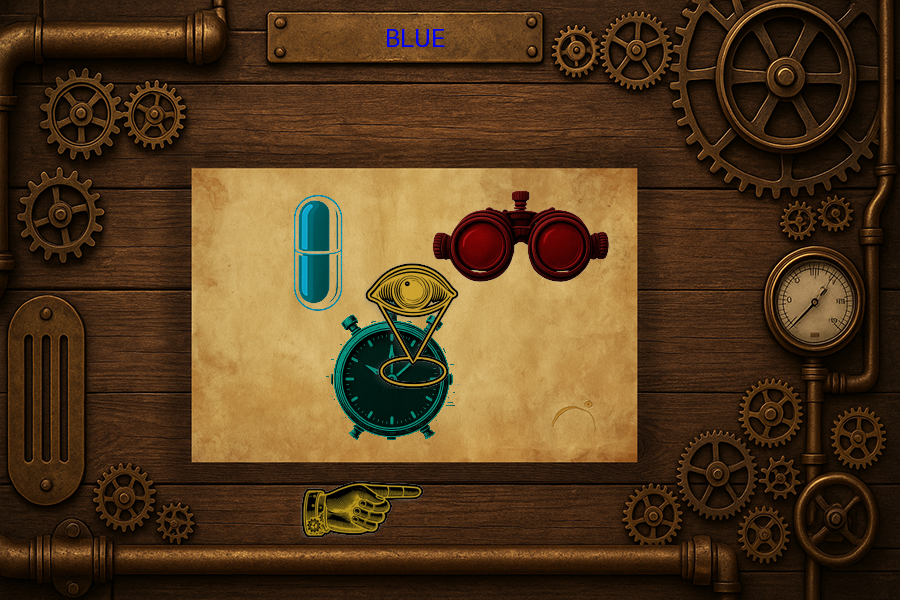

In [10]:
num_steps = 160
demo = demo4(arch, eye_field="attention_field", hand_field="action_field")
recording = demo.run(num_steps)

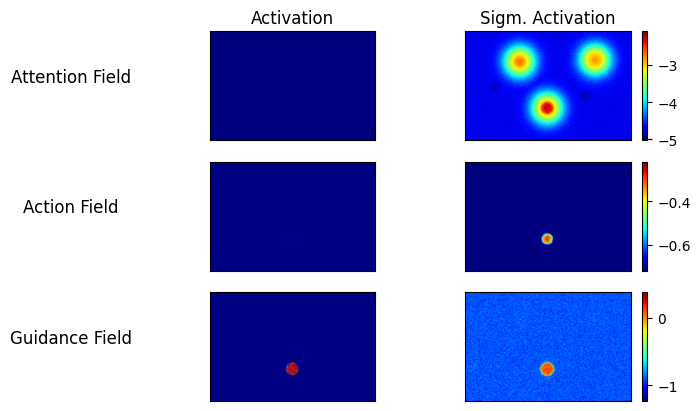

In [11]:
demo.plot()